## En esta parte agrego delta scutis que salieron hace muy poco! 

In [ ]:
import pandas as pd

In [ ]:
ident = pd.read_csv("ident.dat",delim_whitespace=True,names=["ID","Subtype","RA","DEC","field","other","a","b","c"])

In [ ]:
star_info = [
    "ID",
    "Intensity mean I-band magnitude",
    "Intensity mean V-band magnitude",
    "per",
    "Uncertainty of primary period",
    "Time of maximum brightness (HJD-2450000)",
    "I-band amplitude (maximum-minimum)",
    "Fourier coefficient R_21",
    "Fourier coefficient phi_21",
    "Fourier coefficient R_31",
    "Fourier coefficient phi_31",
    "Secondary period (if available)",
    "Uncertainty of secondary period",
    "aTime of maximum brightness (HJD-2450000)",
    "aI-band amplitude (maximum-minimum)",
    "Fourier coefficient R_21 (2)",
    "Fourier coefficient phi_21 (2)",
    "Fourier coefficient R_31 (2)",
    "Fourier coefficient phi_31 (2)",
    "Tertiary period (if available)",
    "Uncertainty of tertiary period",
    "Time of maximum brightness (HJD-2450000) (3)",
    "I-band amplitude (maximum-minimum) (2)",
    "Fourier coefficient R_21 (3)",
    "Fourier coefficient phi_21 (3)",
    "Fourier coefficient R_31 (3)",
    "Fourier coefficient phi_31 (3)"
]


In [ ]:
dsct = pd.read_csv("dsct.dat",delim_whitespace=True,names=star_info)

In [ ]:
ident["types"] = "dsct"
ident["database"] = 4
ident["field"] = "smc"

In [ ]:
dsct = dsct[["ID","per"]].merge(ident[["ID","Subtype","RA","DEC","types","database","field"]],how="inner",on="ID")

In [ ]:
catalog = pd.read_csv("catalogos/0_catalog.csv")

In [ ]:
catalog = pd.concat([catalog,dsct])

In [ ]:
catalog.to_csv("catalogos/0_catalog.csv",index=False)

In [ ]:
ray.shutdown()

In [ ]:
ray.init()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


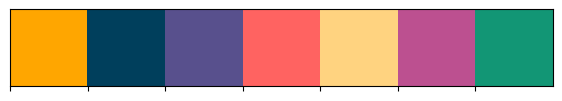

In [1]:
# Importaciones de bibliotecas estándar
# Importaciones de bibliotecas de sistema
import os
import gc
import time
import shutil

# Importaciones de bibliotecas de terceros
import wget
import scipy.signal
import h5py
import psutil
import ray

# Importaciones de TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from keras import backend as K 

# Importaciones de sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.datasets import make_classification
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
# Importaciones de pandas
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# Importaciones de matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.core.pylabtools import figsize, getfigs
%matplotlib inline

# Importaciones de seaborn
import seaborn as sns
gyr = ["#ffa600",
        '#003f5c',
       "#58508d",
       "#ff6361",
       "#ffd380",
       "#bc5090",
       "#129675"
      ]
palet = sns.palplot(sns.color_palette(gyr))
sns.set_context("paper")

# Importaciones de plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Importaciones de numpy
import numpy as np

# Importaciones de astropy
from astropy.io import fits
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
import astropy.units as u

# Importaciones para el equilibrio de los datos
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import RandomUnderSampler


# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

# Obtén el número de CPUs
num_cpus = psutil.cpu_count(logical=False)


class BalancedDataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras Sequence based data generator. 
       Suitable for building data generator for training and prediction.
    """
    def __init__(self, x, y, batch_size=64):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.classes = np.unique(y)
        self.class_indices = [np.where(y == i)[0] for i in self.classes]
        self.length = min([len(i) for i in self.class_indices]) // self.batch_size * len(self.classes)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        for class_index in self.class_indices:
            i = idx % (len(class_index) // self.batch_size)
            batch_x.append(self.x[class_index[i * self.batch_size:(i + 1) * self.batch_size]])
            batch_y.append(self.y[class_index[i * self.batch_size:(i + 1) * self.batch_size]])
        return np.concatenate(batch_x), np.concatenate(batch_y)

    def on_epoch_end(self):
        for class_index in self.class_indices:
            np.random.shuffle(class_index)


# Funciones
def descarga_wget(database,ID,path_3,path_4):
    _,field,types,_ = ID.lower().split("-")
    try :
        if types=="ell":
            types="ecl"
        if database==4:
            if ((field =="blg") |(field =="gd"))&((types =="ecl")|(types =="lpv")|(types =="dsct")):
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot_ogle4/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
            else:
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
                
        if database==3:
            url = "http://ftp.astrouw.edu.pl/ogle/ogle3/OIII-CVS/" +field+"/"+types+"/phot/I/"+ ID +".dat"
            wget.download(url,path_3)
            return 1
    except:
        return 0
            
@ray.remote
def review_open_data(nomb,path_datos,database):
        path= path_datos[database]
        try :
            df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["jd","mag","err"])
            df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )]
            obs_eliminadas = len(df) - len(df_sigma)
            amplitud = df_sigma["mag"].max() - df_sigma["mag"].min()
            mag_mean = df_sigma["mag"].mean()
            mag_std = df_sigma["mag"].std()
            err_mean = df_sigma["err"].mean()
            err_std = df_sigma["err"].std()
            obs_final = len(df_sigma)
            obs_inicial = len(df)
            return 1,nomb,database,obs_eliminadas,amplitud,mag_mean,mag_std,err_mean,err_std,obs_final,obs_inicial
        except:
            return 0,nomb,database,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

        
def ra_dec_to_degrees(ra_str, dec_str):
    # Convertir las coordenadas RA y DEC en objetos SkyCoord
    coord = SkyCoord(ra=ra_str, dec=dec_str, unit=(u.hourangle, u.deg))

    # Obtener las coordenadas en grados
    ra_deg = coord.ra.degree
    dec_deg = coord.dec.degree

    return ra_deg, dec_deg

def fase_datos(path_datos,database,nomb,per_vsx):
    path= path_datos[database]
    df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["jd","mag","err"])
    df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )]
    if len(df_sigma)>2000:
        df_sigma = df_sigma.sample(2000,random_state=42).reset_index(drop=True)
    fase_vsx = np.mod(df_sigma.jd, per_vsx) / per_vsx
    mag_vsx,t_vsx,err_vsx =df_sigma.mag,df_sigma.jd,df_sigma.err
    return fase_vsx,mag_vsx,t_vsx

def make_2d_histogram(n_bins_x,n_bins_y,data_mag,data_fase,norm_max):
    bins_x = np.linspace(0,1, n_bins_x) # Curves in phase between 0 and 2.
    bins_y = np.linspace( data_mag.min(), data_mag.max(), n_bins_y)
    hist_data, _xbins, _ybins = np.histogram2d(data_fase, data_mag, bins=(bins_x, bins_y))
    # Data in histogram is transposed, then transpose it just once:
    if norm_max=="max":
        norm_max = hist_data.max()
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu
    else:
        norm_max = float(norm_max)
        hist_data[hist_data > norm_max ] = norm_max
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu

def split_random(df,numero_dividir,col_name):
    for types in df["types"].unique():
        df_var = df.loc[df["types"]==types].sample(numero_dividir,random_state=42)
        df_train,df_test = train_test_split(df_var,random_state=42,test_size=0.13)
        df_train,df_val = train_test_split(df_train,random_state=42,test_size=0.15)
        df.loc[df_train.index,col_name] = "train"
        df.loc[df_val.index,col_name] = "val"
        df.loc[df_test.index,col_name] = "test"
    return df
    

def split_data_balanced(df,numero_dividir):
    df["combined"] = list(zip(df["obs_final"],
                          df["amplitud"],
                          df["mag_mean"],
                          df["mag_std"],
                          df["field"],
                         df["err_mean"],
                         df["per"],
                         df["err_std"]))
    combined_weight = df['combined'].value_counts(normalize=True)
    df['combined_weight'] = df['combined'].apply(lambda x: combined_weight[x])
    subsample = df.sample(numero_dividir, weights=df['combined_weight'])
    for types in df["types"].unique():
        df_var = df.loc[df["types"]==types].sample(numero_dividir,
                                                             weights=df['combined_weight'],
                                                             random_state=42)
        df_train = df_var.sample(frac=0.8,
                         weights=df['combined_weight'],
                         random_state=42)
        df_var = df_var.drop(df_train.index)
        
        df_val = df_var.sample(frac=0.5,
                         weights=df['combined_weight'],
                         random_state=42)
        
        df_test = df_var.drop(df_val.index)
        
        df.loc[df_train.index,"entrenamiento_8mil_balanced"] = "train"
        df.loc[df_val.index,"entrenamiento_8mil_balanced"] = "val"
        df.loc[df_test.index,"entrenamiento_8mil_balanced"] = "test"
            
        
    return df

def plot_obs_dist(df,split_name):
    sns.set_context("paper")
    gyr = ["#890B96",'#FFCF3D',"#129675"]
    sns.set_palette(gyr)

    columns = ["obs_final", "amplitud", "mag_mean", "field", "err_mean", "per", "mag_std", "err_std"]
    labels = [r'$n_{obs}$', r'$Amplitude$', 'Mean Magnitude', "Field", 'Mean Error', 'Period', 
              'Magnitude standard deviations', 'Magnitude Error standard deviations']
    log_scales = [True, True, False, False, True, True, True, False]
    x_ticks = [[10**2,10**3,10**4], [10**-1,1,10**1], None, None, [10**-2,10**-1,10**0], [10**-1,10**1,10**3],
               None, [0,0.3,0.6]]
    y_scale_log = [False, False, False, False, False, False, False, True]

    fig, axes = plt.subplots(4, 2, figsize=(7,15))

    for i, ax in enumerate(axes.flatten()):
        sns.histplot(ax=ax, data=df, x=columns[i], hue=split_name, bins=30,
                     stat="density", log_scale=log_scales[i], fill=True, common_norm=False)
        ax.set(xlabel=labels[i], ylabel="")
        if x_ticks[i] is not None:
            ax.set_xticks(x_ticks[i])
        if y_scale_log[i]:
            ax.set_yscale("log")
        if i != 0: # remove legend for all but the first subplot
            ax.get_legend().remove()

    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)
    fig.tight_layout()
    fig.text(-0.01,0.5,"Density", size=13, rotation=90)
    fig.tight_layout()
    

def plot_histograms(df, estrellas, path_datos,norm):
    estrellas_plot = df.loc[df["ID"].isin(estrellas)].reset_index(drop=True)

    fig, ax = plt.subplots(len(estrellas), 2, figsize=(5,10), sharex="col")
    for i in range(len(estrellas_plot)):
        fase, mag, t_vsx = fase_datos(path_datos, estrellas_plot["database"][i], estrellas_plot["ID"][i], estrellas_plot["per"][i])

        ax[i,0].set_ylim(mag.max(), mag.min())
        ax[i,0].set_yticks(np.linspace(mag.min() + (mag.max() - mag.min()) /10, mag.max() - (mag.max() - mag.min()) /10, 4))
        ax[i,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        sns.scatterplot(x=fase, y=mag, c=t_vsx, s=5, ax=ax[i,0])

        hdu = make_2d_histogram(32+1, 32+1, mag, fase, norm_max=norm)
        ax[i,1].imshow(hdu.data, interpolation='nearest', aspect='auto')
        ax[i,1].set_yticklabels([])
        ax[i,1].set_xticklabels([])

    fig.text(0.5, 0, "Phase", size=13)
    fig.text(-0.01, 0.5, "I Mag", size=13, rotation=90)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig("hist_2d_fase.pdf", bbox_inches="tight", pad_inches=0)
    return hdu 

@ray.remote
def make_lc_hist(nomb,
                 per_vsx,
                 path_datos,
                 database,
                 aug,
                 rng,
                 g,
                 bins,
                N):
        path= path_datos[database]
        df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["d","mag","e"])
        df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )].reset_index(drop=True)
        if int(aug) == 0:
            df_sigma["fase"] = np.mod(df_sigma.d, per_vsx) / per_vsx
            if len(df_sigma)>2000:
                df_sigma = df_sigma.sample(2000,random_state=42)
            hdu =make_2d_histogram(32+1,32+1,df_sigma.mag,df_sigma.fase, norm_max=7)
            return hdu.data
        
        if int(aug) == 1:
            df_sigma["fase"] =  np.mod(df_sigma.d - g, per_vsx) / per_vsx
            df_sigma["mag"] = df_sigma["mag"] + rng.normal(0, df_sigma["e"],len(df_sigma))
            df_sigma["fase_bin"] = pd.cut(df_sigma["fase"],bins=int(bins))
            df_bins = pd.DataFrame(df_sigma.groupby("fase_bin")["fase"].mean())
            df_bins["mag"] = df_sigma.groupby("fase_bin")["mag"].mean()
            df_bins["e"] = df_sigma.groupby("fase_bin")["e"].mean()
            df_bins["d"] = df_sigma.groupby("fase_bin")["d"].mean()
            hdu =make_2d_histogram(32+1,32+1,df_bins.mag,df_bins.fase,norm_max=N)
            return hdu.data

def create_hdf5(df,path_datos,rng):
    results_ids = []
    for i in range(len(df)):
        hdu = make_lc_hist.remote(df["ID"][i],
                                  df["per"][i],
                                  path_datos,
                                  df["database"][i],
                                  df["aug"][i],
                                  rng,
                                  df["g"][i],
                                  df["bins"][i],
                                 df["N"][i])
        results_ids.append((hdu))
    x = np.empty((len(df), 32, 32))
    for i,key in enumerate(results_ids):
        ima = ray.get(key)
        x[i] = ima
    x = np.expand_dims(x, axis=3)
    return x

def make_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(32, 32, 1),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(16, (3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(32, (3, 3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.3),
   # tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=0.1), loss="sparse_categorical_crossentropy", metrics=['acc'])
    return model

def train_models(df_lista, keys_lista, data, prueba_8mil,epochs=200, use_balanced_generator=False):
    tf.random.set_seed(42)

    validation_datagen = ImageDataGenerator()
    idx_val = prueba_8mil.loc[prueba_8mil['prueba_13080mil']=="val"].index.values
    val_label = data['prueba_13080mil_label'][idx_val]
    val_data = data["prueba_13080mil"][idx_val]
    val_gen = validation_datagen.flow(val_data, val_label, batch_size=32, shuffle=True)

    for df, test_name in zip(df_lista, keys_lista):
        K.clear_session()
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

        model_history_log_file = f"history_softmax_{'batchBalanced_' if use_balanced_generator else ''}{test_name}.csv"
        csv_logger = CSVLogger(model_history_log_file, append=False)

        checkpoint_path = f"training_softmax_{'batchBalanced_' if use_balanced_generator else ''}{test_name}/cp.ckpt"
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=False, verbose=1)

        callbacks = [csv_logger, cp_callback, early_stopping]
        
        if use_balanced_generator:
            idx_train = df.loc[(df[test_name]!="test")&(df[test_name]!="val")&(df["aug"]==0)].index.values
        else :
            idx_train = df.loc[(df[test_name]!="test")&(df[test_name]!="val")].index.values

        bz = int((len(idx_train) * 64)/ len(prueba_8mil.loc[prueba_8mil['prueba_13080mil']=="train"]))
    
        train_label = data[f'{test_name}_label'][idx_train]
        
        train_data = data[test_name][idx_train]
        
        if use_balanced_generator:
            train_gen = BalancedDataGenerator(train_data, train_label, batch_size=64)
        else:
            train_datagen = ImageDataGenerator()
            train_gen = train_datagen.flow(train_data, train_label, batch_size=bz, shuffle=True)

        model = make_model()
        print(f"Use balanced Generator [{use_balanced_generator}] \n Data: {len(train_data)} \n -----------------------------------------------------------------------------------")
        history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
    return

    
def augmented_to(ID,count,df):
    a = (np.linspace(0,9,count)*100).astype(int)
    np.sort(rng.uniform(low=0 + 1/32, high=1 - 1/32, size=1000))[a]
    df.loc[df["ID"]==ID,"g"] = np.sort(rng.uniform(low=0 + 1/32, high=1 - 1/32, size=1000))[a]
    return

def plot_accuracy_and_loss(path,file_names, title_names, amarillo_train, purpura_val, output_file="training_.pdf"):
    plt.rcParams["figure.figsize"] = (18,8)
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(2, len(file_names), sharex="col", sharey="row")
    metrics = ["acc", "val_acc", "loss", "val_loss"]
    labels = ['Training data Augmentation', 'Validation data Augmentation', 'Training data Augmentation', 'Validation data Augmentation']
    labels_batch = ['Training batch balanced', 'Validation batch balanced', 'Training batch balanced', 'Validation batch balanced']    
    colors = [amarillo_train, purpura_val, amarillo_train, purpura_val]
    linestyles = ["-.", ".as", "dashdot", "dashdot"]

    for i, file_name in enumerate(file_names):
        batch_name = file_name.split("softmax")[0]+"softmax_batchBalanced"+file_name.split("softmax")[1]
        df = pd.read_csv(f"{path}/{file_name}.csv")
        df_batch = pd.read_csv(f"{path}/{batch_name}.csv")

        for j, metric in enumerate(metrics):
            sns.lineplot(ax=axs[j//2, i], data=df, x="epoch", y=metric, 
                         color=colors[j], label=labels[j], linestyle="solid")
            if i > 0:
                sns.lineplot(ax=axs[j//2, i], data=df_batch, x="epoch", y=metric, 
                             color=colors[j], label=labels_batch[j], linestyle="dashed")

        axs[0,i].set_title(title_names[i])
        axs[0,i].set_ylim([0.6,1])
        axs[1,i].set_ylim([0.6,1])
        axs[0,i].set_yticks(np.linspace(0.6,1,8))
        axs[1,i].set_yticks(np.linspace(0,0.9,8))
        axs[0,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[1,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[1,i].set_xlabel('Epoch')

        axs[0,i].get_legend().remove()
        axs[1,i].get_legend().remove()

    axs[0,0].set_ylabel('Accuracy')
    axs[1,0].set_ylabel('Loss')

    handles, labels = axs[1,2].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.19,0.5), ncol=4, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.savefig(output_file, bbox_inches="tight")
    return
def run_analysis(tests,titles,entrenamiento,filename="../data_Paper_OGLE/Data_08Sep.hdf5",
                 csv_file="../data_Paper_OGLE/catalogos/prueba_8mil.csv"):
    # Load data
    data = h5py.File(filename, 'r+')
    df_8mil = pd.read_csv(csv_file)
    idx_test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"].index.values
    test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"]
    test = test.drop(columns={"prueba_8mil","aug","g","bins","GroupID","GroupSize"})
    
    # Prepare data generator
    test_datagen = ImageDataGenerator()
    test_gen = test_datagen.flow(
        data["prueba_13080mil"][idx_test],
        data["prueba_13080mil_label"][idx_test],
        batch_size=32
    )
    
    sns.set_context("paper",font_scale=3)
    model = make_model()

    num_tests = len(tests)
    rows = 2  # Ahora queremos 2 filas
    cols = 3  # Y 3 columnas

    fig, ax = plt.subplots(rows, cols, figsize=(11*3, 10*2), sharey="row")
    plt.subplots_adjust(wspace=0, hspace=0.2, right=0.7)

    # Aplanar el array de ejes para iterar fácilmente
    ax = ax.ravel()

    for i, prueba in enumerate(tests):
        model.load_weights(f"{entrenamiento}/{prueba}/cp.ckpt")
        prediction(test, test_gen, model, prueba)

        # Calculate F1 Score
        f1 = f1_score(test_gen.y, test[f"label_predict_{prueba}"], average='weighted')

        # Plots
        array, annot = C_M(test_gen.y, test[f"label_predict_{prueba}"])
        sns.heatmap(array, annot=annot, fmt='', vmin=0, vmax=np.sum(array, axis=1)[0], cmap="BuPu",
                    annot_kws={"fontsize":25}, linewidth=1, ax=ax[i], cbar=False)
        ax[i].set_yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])
        ax[i].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])
        ax[i].set_yticklabels(['ELL', 'Mira', 'CEP', 'DST', 'ECL', 'LPV', 'RRL', "Rndm"])
        ax[i].set_xticklabels(['ELL', 'Mira', 'CEP', 'DST', 'ECL', 'LPV', 'RRL', "Rndm"], rotation=45)
        prueba = prueba.split("prueba")[1]
        # Add title and F1 Score
        ax[i].set_title(f'{titles[i]}\nF1 Score: {f1:.3f}')

    # Eliminar el último subplot si el número de tests no llena todos los subplots
    if num_tests < rows * cols:
        fig.delaxes(ax[-1])

    # Etiqueta general para el eje y
    fig.text(-0.02, 0.5, 'True Label', va='center', rotation='vertical', fontsize=30)

    # Etiqueta general para el eje x
    fig.text(0.5, -0.02, 'Predicted Label', ha='center', fontsize=30)

    fig.tight_layout(pad=0)
    plt.savefig("CM.pdf", bbox_inches="tight")
    return test

def prediction(df,image_gen,model,prueba):
    %matplotlib inline
    grupos = ['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"random"]
    label_predict = []
    porcentaje_predict = []
    nombres = []
    for i in model.predict(image_gen.x):
        idx = np.argmax(i)
        label_predict.append(np.argmax(i))
        porcentaje_predict.append(i[idx])
        nombres.append(grupos[np.argmax(i)])
    df[f"label_predict_{prueba}"] = label_predict
    df[f"porcentaje_predict_{prueba}"] = porcentaje_predict
    df[f"nombres_predict_{prueba}"] = nombres
    return

def C_M(label,predict_label):
    array = np.array(tf.math.confusion_matrix(label,predict_label) )
    df = pd.DataFrame(array)
    perc = df.copy()
    cols=perc.columns.values
    perc[cols]=perc[cols].div(perc[cols].sum(axis=1), axis=0).multiply(100)
    annot=df.round(2).astype(str) + "\n" + perc.round(1).astype(str) + "%"
    return array,annot

def metricas(labels,predict):
    print("Accuracy:", "%0.2f" % metrics.accuracy_score(labels,predict))
    print("macro precision: ","%0.2f" %  metrics.precision_score(labels,predict, average='macro'))
    print("macro recall: ","%0.2f" %  metrics.recall_score(labels,predict, average='macro'))
    print("macro F1: ","%0.2f" %  metrics.f1_score(labels,predict, average='macro'))
    print(metrics.classification_report(labels,predict, digits=2))
    report = metrics.classification_report(labels,predict, output_dict=True, digits=2)
    return report

def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=500, random_state=42):
    # Crea el clasificador Random Forest
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # Entrena el clasificador
    clf.fit(X_train, y_train)
    
    # Predice las clases para el conjunto de test
    y_pred = clf.predict(X_test)
    
    # Crea una figura y ejes para la trama
    fig, ax = plt.subplots(figsize=(8, 8))

    array, annot = C_M(y_test, y_pred)
    sns.heatmap(array, annot=annot, fmt='', vmin=0, vmax=np.sum(array, axis=1)[0], cmap="BuPu",
                annot_kws={"fontsize":15}, linewidth=1, ax=ax, cbar=False)
    
    ax.set_yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    ax.set_yticklabels(['ELL', 'Mira', 'Cep', 'Dsct', 'Ecl', 'Lpv', 'RRlyr'], fontsize=20)
    ax.set_ylabel('True Label', fontsize=20)
    
    ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    ax.set_xticklabels(['ELL', 'Mira', 'Cep', 'Dsct', 'Ecl', 'Lpv', 'RRlyr'], fontsize=20)
    ax.set_xlabel('Predicted Label', fontsize=20)
    
    # Add title and F1 Score
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    ax.set_title(f'Random Forest\nF1 Score: {f1:.2f}', fontsize=20)

    fig.tight_layout(pad=0)
    plt.savefig("CNN_And_RF.pdf", bbox_inches="tight")

    return clf, y_pred

datos = "/dataworkspace/datos_ogle/datos"

path_datos_4 = datos + "/datos_ogle_4/I"

path_datos_3 = datos + "/datos_ogle_3/I"
path_datos = ["_","_","_",path_datos_3,path_datos_4]

rng = np.random.default_rng(42)
    

In [ ]:
catalog = pd.read_csv("catalogos/0_catalog.csv")

In [ ]:
%%time
results_ids = []
for i in range(len(catalog)):
    results_ids.append(review_open_data.remote(catalog["ID"][i],path_datos,catalog["database"][i]))                                                                                                               

In [ ]:
%%time
df = pd.DataFrame(ray.get(results_ids),columns=["error",
                                            "ID", "database",
                                        "obs_eliminadas",
                                        "amplitud",
                                        "mag_mean",
                                        "mag_std",
                                        "err_mean",
                                        "err_std",
                                        "obs_final",
                                        "obs_inicial"])

In [ ]:
catalog = catalog[['ID', 'RA', 'DEC', 'types', 'database', 'field', 'Subtype', 'per']].merge(df,how="inner",on=["ID","database"])

In [ ]:
a, b = ra_dec_to_degrees(catalog["RA"],catalog["DEC"])

In [ ]:
catalog["ra_deg"] = a
catalog["dec_deg"] = b

In [ ]:
catalog.to_csv("/home/variablestars/Nico/ogle_06_03_23/catalogos/0_catalog_descriptivo.csv",index=False)

## Revisar Descarga

In [ ]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo.csv")

In [ ]:
error_descarga = catalog.loc[catalog["error"]==0]

In [ ]:
test_descarga = catalog.drop_duplicates(subset=["types","field","database"])

In [ ]:
%%time
test_descarga["error"] = test_descarga.apply(lambda row: descarga_wget(row["database"],
                                                                       row["ID"],
                                                                      path_datos_3,
                                                                      path_datos_4),axis=1)

In [ ]:
%%time
error_descarga["descarga_wget"] = error_descarga.apply(lambda row: descarga_wget(row["database"],
                                                                       row["ID"],
                                                                      path_datos_3,
                                                                      path_datos_4),axis=1)

In [ ]:
error_descarga.loc[error_descarga["descarga_wget"]!=0]

## Distribuciones

In [ ]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo.csv")

In [ ]:
df = catalog.groupby("types").count()[["ID"]].rename(columns={"ID":"Catalogo"})

In [ ]:
catalog = catalog.loc[catalog["error"]!=0]

In [ ]:
df["error download"] = df[["Catalogo"]].rename(columns={"Catalogo":"ID"}) - catalog.groupby("types").count()[["ID"]]

In [ ]:
catalog = catalog.loc[(catalog["obs_final"]!=0)] 
sns.histplot(data=catalog,x="obs_final",bins=30,hue="types"
             ,palette=sns.color_palette(gyr),log_scale=True,
    stat="density", common_norm=False)
plt.axvline(x=2000, color = 'r')
plt.axvline(x=60, color = 'r')
plt.savefig("paper_observaciones_final.pdf")

In [ ]:
df["Observaciones<60"] = catalog.loc[(catalog["obs_final"]<=60)|
                                     (catalog["obs_final"]==0)
                                    ].groupby("types").count()[["ID"]]

In [ ]:
catalog = catalog.loc[(catalog["obs_final"]>60)] # aproximadamente 1 % de la mmuestra

In [ ]:
sns.histplot(data=catalog,x=catalog["obs_eliminadas"] / catalog["obs_inicial"],bins=50,hue="types",palette="Paired")

In [ ]:
catalog = catalog.sort_values(by="database",ascending=False).reset_index(drop=True)

In [ ]:
df["Duplicated ID"] = catalog.loc[catalog.duplicated(subset="ID")].groupby("types").count()[["ID"]]

In [ ]:
catalog = catalog.drop_duplicates(subset="ID",keep="first").reset_index(drop=True)

In [ ]:
catalog.groupby("types").count()

In [ ]:
catalog.to_csv("catalogos/0_catalog_descriptivo_antes_de_topcat.csv")

In [ ]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo_antes_de_topcat.csv")

In [ ]:
catalog_t = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")

In [ ]:
catalog_t = catalog_t.loc[catalog_t["GroupID"].isna()].drop(columns={"col1"}).reset_index(drop=True)

In [ ]:
catalog.groupby("types").count()[["ID"]] - catalog_t.groupby("types").count()[["ID"]]

In [ ]:
df["Topcat"] = catalog.groupby("types").count()[["ID"]] - catalog_t.groupby("types").count()[["ID"]]

In [ ]:
df["final"] = catalog_t.groupby("types").count()[["ID"]]

In [ ]:
df = df.fillna(0)


In [ ]:
df["Catalogo"] - df["error download"] - df["Observaciones<60"] - df["Duplicated ID"] - df["Topcat"]

In [ ]:
catalog = catalog.loc[catalog["per"]!=0]

In [ ]:
cep_min = catalog.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]

### Split Data

In [ ]:

rng = np.random.default_rng(42)
datos = "/media/variablestars/datos1/datos_ogle/datos"
path_datos_4 = datos + "/datos_ogle_4/I"

path_datos_3 = datos + "/datos_ogle_3/I"
path_datos = ["_","_","_",path_datos_3,path_datos_4]

In [ ]:
catalog = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")

In [ ]:
catalog = catalog.drop(columns={"col1"})
catalog = catalog.loc[catalog["per"]!=0]

In [ ]:
cep_min = catalog.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]

In [ ]:
df_split_random = split_random(catalog,cep_min,"entrenamiento_8mil_balanced")

In [ ]:
df_split_data_balanced = split_data_balanced(catalog,cep_min)

In [ ]:
df_split_data_balanced = df_split_data_balanced.loc[df_split_data_balanced["entrenamiento_8mil_balanced"].notna()]

In [ ]:
#df_split_random = df_split_random.loc[df_split_random["entrenamiento_8mil_randm"].notna()]

In [ ]:
#plot_obs_dist(df_split_random,"entrenamiento_8mil_randm")

In [ ]:
plot_obs_dist(df_split_data_balanced,"entrenamiento_8mil_balanced")

In [ ]:
prueba_8mil = df_split_random.loc[df_split_random["entrenamiento_8mil_balanced"].notna()]

In [ ]:

estrellas = ['OGLE-GD-RRLYR-04519', 'OGLE-BLG-LPV-240852', "OGLE-SMC-ECL-2344", "OGLE-LMC-CEP-2430", 'OGLE-LMC-LPV-83641', "OGLE-BLG-DSCT-00245", "OGLE-BLG-ELL-007122"]

a = plot_histograms(prueba_8mil, estrellas, path_datos,10)



## Augmented data

In [ ]:
ogle = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")
ogle = ogle.drop(columns={"col1"})
ogle = ogle.loc[ogle["per"]!=0]
ogle = ogle[ogle["per"].notna()].reset_index(drop=True)
le = preprocessing.LabelEncoder()
le.fit(ogle.types)
ogle["categorical_label"] = le.transform(ogle.types)
cep_min = ogle.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]
ogle = split_random(ogle,cep_min,"prueba_8mil")
prueba_8mil = ogle.dropna(subset="prueba_8mil")

In [ ]:

ogle = pd.read_csv("catalogos/0_catalog_descriptivo_despues_de_topcat.csv")
ogle = ogle.drop(columns={"col1"})
ogle = ogle.loc[ogle["per"]!=0]
ogle = ogle[ogle["per"].notna()].reset_index(drop=True)
le = preprocessing.LabelEncoder()
le.fit(ogle.types)
ogle["categorical_label"] = le.transform(ogle.types)
cep_min = ogle.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]
ogle = split_random(ogle,cep_min,"prueba_8mil")
prueba_8mil = ogle.dropna(subset="prueba_8mil")

ogle = ogle[~ogle["ID"].isin(prueba_8mil["ID"])].reset_index(drop=True)

prueba_23_mil = pd.DataFrame()
for types in ogle["types"].unique():
    df_types = ogle.loc[ogle["types"]==types].reset_index(drop=True)
    if len(df_types)> 15065:
        df_types = df_types.sample(15065,random_state=42).reset_index(drop=True)
    prueba_23_mil = pd.concat([prueba_23_mil,df_types])

train_8mil = prueba_8mil.loc[prueba_8mil["prueba_8mil"] == "train"].reset_index(drop=True)

prueba_23_mil = pd.concat([prueba_23_mil,train_8mil])

for types in prueba_23_mil["types"].unique():
    df_types = prueba_23_mil.loc[prueba_23_mil["types"]==types].reset_index(drop=True)
    resto = 24168 % len(df_types)
    if 24168 // len(df_types) > 1:
        repetir = 24168 // len(df_types) -1 
        prueba_23_mil = pd.concat([prueba_23_mil,pd.concat([df_types]*repetir)])
        prueba_23_mil = pd.concat([prueba_23_mil,df_types.sample(resto,random_state=42)])
    if 24168 // len(df_types) == 1:
        prueba_23_mil = pd.concat([prueba_23_mil,df_types.sample(resto,random_state=42)])
    

ogle = ogle[~ogle["ID"].isin(prueba_23_mil["ID"])].reset_index(drop=True)
ogle.groupby("types").count()

prueba_60_mil = pd.DataFrame()
for types in ogle["types"].unique():
    df_types = ogle.loc[ogle["types"]==types].reset_index(drop=True)
    if len(df_types)>= 36838:
        df_types = df_types.sample(36838,random_state=42).reset_index(drop=True)
    prueba_60_mil = pd.concat([prueba_60_mil,df_types])

prueba_60_mil = pd.concat([prueba_60_mil,prueba_23_mil],axis=0)

for types in prueba_60_mil["types"].unique():
    df_types = prueba_60_mil.loc[prueba_60_mil["types"]==types].reset_index(drop=True)
    resto = 61006 % len(df_types)
    if 61006 // len(df_types) > 1:
        repetir = 61006 // len(df_types) -1
        prueba_60_mil = pd.concat([prueba_60_mil,pd.concat([df_types]*repetir)])
        prueba_60_mil = pd.concat([prueba_60_mil,df_types.sample(resto,random_state=42)])
    if 61006 // len(df_types) == 1:
        prueba_60_mil = pd.concat([prueba_60_mil,df_types.sample(resto,random_state=42)])

ogle = ogle[~ogle["ID"].isin(prueba_60_mil["ID"])].reset_index(drop=True)

prueba_23_mil.loc[prueba_23_mil.duplicated(subset="ID"),"aug"] = 1
prueba_23_mil.loc[prueba_23_mil["aug"].isna(),"aug"] = 0

prueba_60_mil.loc[prueba_60_mil.duplicated(subset="ID"),"aug"] = 1
prueba_60_mil.loc[prueba_60_mil["aug"].isna(),"aug"] = 0

df_aux = prueba_23_mil.groupby("ID").count()[["RA"]].reset_index().rename(columns={"RA":"count"})
prueba_23_mil = prueba_23_mil.merge(df_aux,how="left",on="ID")


df_aux = prueba_60_mil.groupby("ID").count()[["RA"]].reset_index().rename(columns={"RA":"count"})
prueba_60_mil = prueba_60_mil.merge(df_aux,how="left",on="ID")

prueba_23_mil.loc[prueba_23_mil["count"]>1].drop_duplicates(subset="ID").parallel_apply(lambda row: augmented_to(row["ID"],row["count"],prueba_23_mil),axis=1)
prueba_23_mil.loc[prueba_23_mil["aug"]==1,"bins"] = prueba_23_mil.loc[prueba_23_mil["aug"]==1].parallel_apply(lambda row: rng.choice(np.arange(int(row["obs_final"]*0.5),
                                           int(row["obs_final"]*0.7))),axis=1)
prueba_23_mil.loc[prueba_23_mil["bins"]>2000,"bins"] = rng.choice(np.arange(1000,1500),len(prueba_23_mil.loc[prueba_23_mil["bins"]>2000]))
prueba_23_mil_sin_aug = prueba_23_mil.loc[prueba_23_mil["aug"]==0].reset_index(drop=True)

prueba_60_mil.loc[prueba_60_mil["count"]>1].drop_duplicates(subset="ID").parallel_apply(lambda row: augmented_to(row["ID"],row["count"],prueba_60_mil),axis=1)
prueba_60_mil.loc[prueba_60_mil["aug"]==1,"bins"] = prueba_60_mil.loc[prueba_60_mil["aug"]==1].parallel_apply(lambda row: rng.choice(np.arange(int(row["obs_final"]*0.5),
                                           int(row["obs_final"]*0.8))),axis=1)
prueba_60_mil.loc[prueba_60_mil["bins"]>2000,"bins"] = rng.choice(np.arange(1000,1500),len(prueba_60_mil.loc[prueba_60_mil["bins"]>2000]))
prueba_60_mil_sin_aug = prueba_60_mil.loc[prueba_60_mil["aug"]==0].reset_index(drop=True)


In [ ]:
prueba_8mil["aug"] = 0
prueba_8mil["g"] = np.nan
prueba_8mil["bins"] = np.nan
prueba_8mil["N"] = np.nan

ogle["aug"] = 0
ogle["g"] = np.nan
ogle["bins"] = np.nan
ogle["N"] = np.nan


prueba_23_mil["g"] = rng.uniform(low=0 + 1/32, high=1 - 1/32, size=len(prueba_23_mil))*prueba_23_mil["per"]
prueba_60_mil["g"] = rng.uniform(low=0 + 1/32, high=1 - 1/32, size=len(prueba_60_mil))*prueba_60_mil["per"]

valores = [5, 7, 9, 11, 13, 15]

prueba_23_mil["N"] = np.random.choice(valores, len(prueba_23_mil)) 
prueba_60_mil["N"] = np.random.choice(valores, len(prueba_60_mil)) 

In [ ]:
prueba_23_mil.loc[prueba_23_mil["prueba_8mil"].isna(),"prueba_8mil"] = "train"
prueba_60_mil.loc[prueba_60_mil["prueba_8mil"].isna(),"prueba_8mil"] = "train"

In [ ]:

def randomize_per(group):
    size = len(group)
    low = group['per'].min()
    high = group['per'].max()
    group['per'] = np.random.uniform(low=low, high=high, size=size)
    return group


def make_random_period(df,n_star_split="auto"):
    if n_star_split=="auto":
        for split in ["train","val","test"]:
            df_var = df.loc[(df["prueba_8mil"]==split)&(df["aug"]==0)]
            n_star_split = df_var.groupby("categorical_label").count()["ID"].max()
            if np.isnan(n_star_split):
                continue
            if int(n_star_split) <= df_var.groupby("types").count()["ID"].min():
                df_randoms = df_var.groupby("types").sample(int(np.ceil(n_star_split/7)))
                df_randoms = df_randoms.sample(n_star_split)
            else:
                df_randoms = df_var.groupby("types").sample(int(df_var.groupby("types").count()["ID"].min()/7))
                resto = df_var.drop(df_randoms.index, errors='ignore').sample(n_star_split - len(df_randoms))
                df_randoms = pd.concat([df_randoms,resto])
            df_randoms["categorical_label"] = 7
            df_randoms = df_randoms.groupby('types', group_keys=True).apply(randomize_per).reset_index(drop=True)
            df_randoms["types"] = df_randoms["types"] +"_"+ "random"
            df = pd.concat([df,df_randoms])
    else:
        for split in ["train"]:
            df_var = df.loc[(df["prueba_8mil"]==split)&(df["aug"]==0)]
            if np.isnan(n_star_split):
                continue
            if int(n_star_split) <= df_var.groupby("types").count()["ID"].min():
                df_randoms = df_var.groupby("types").sample(int(np.ceil(n_star_split/7)))
                df_randoms = df_randoms.sample(n_star_split)
            else:
                df_randoms = df_var.groupby("types").sample(int(df_var.groupby("types").count()["ID"].min()/7))
                resto = df_var.drop(df_randoms.index, errors='ignore').sample(n_star_split - len(df_randoms))
                df_randoms = pd.concat([df_randoms,resto])
            df_randoms["categorical_label"] = 7
            df_randoms = df_randoms.groupby('types', group_keys=True).apply(randomize_per).reset_index(drop=True)
            df_randoms["types"] = df_randoms["types"] +"_"+ "random"
            df = pd.concat([df,df_randoms])

    return df
    
    

In [ ]:
prueba_8mil_2 = make_random_period(prueba_8mil)
prueba_23_mil_2 =  make_random_period(prueba_23_mil,24168)
prueba_60_mil_2 =  make_random_period(prueba_60_mil,61006)

In [ ]:
prueba_60_mil_2.to_csv("catalogos/prueba_60mil.csv",index=False)
prueba_23_mil_2.to_csv("catalogos/prueba_23mil.csv",index=False)
prueba_8mil_2.to_csv("catalogos/prueba_8mil.csv",index=False)
ogle.to_csv("catalogos/ogle_no_usado.csv",index=False)

## Revisar aumento de datos 

In [ ]:
data = h5py.File("../data_Paper_OGLE/Data_08Sep.hdf5", 'r+')
prueba_60_mil = pd.read_csv("../data_Paper_OGLE/catalogos/prueba_60mil.csv")


In [ ]:
cep_to_plot = prueba_60_mil.loc[prueba_60_mil["types"]=="cep"].head(10)
row = cep_to_plot.drop_duplicates(subset="count")["count"].max()
cep_to_plot_ID = cep_to_plot["ID"]

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,5, figsize=(30,8))
fig.subplots_adjust(hspace=0, wspace=0)
df_star = prueba_60_mil.loc[prueba_60_mil["ID"] == cep_to_plot["ID"].values[0]]
df_star.loc[df_star["bins"].isna(),"N"] = 7
df_star.loc[df_star["bins"].isna(),"g"] = 0
df_star.loc[df_star["bins"].isna(),"bins"] = df_star.loc[df_star["bins"].isna()]["obs_final"]
df_star = df_star.sample(5, random_state=4)
df_star = df_star.sort_values(by="g")

for i, b in enumerate(df_star.index.values):
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    im = data['prueba_69721mil'][b]
    n_obs = df_star["bins"][b]
    phi = df_star["g"][b]
    N = df_star["N"][b]
    axes[i].imshow(im, aspect='auto')
    
    # Definir tamaño de fuente
    font_size = 13  # Puedes ajustar este valor según lo necesites
    
    # Agregar la información línea por línea en la esquina inferior izquierda
    yOffset = 0.05
    step = 0.06
    bbox_props = dict(boxstyle="square,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7)

    axes[i].text(0.05, yOffset, r"$N_{{\mathrm{{Obs}}}}$: {}".format(n_obs), transform=axes[i].transAxes, 
                 color='black', backgroundcolor='white', verticalalignment='bottom', bbox=bbox_props, fontsize=font_size)
    yOffset += step
    axes[i].text(0.05, yOffset, r"$\phi'$: {}".format(round(phi,3)), transform=axes[i].transAxes, 
                 color='black', backgroundcolor='white', verticalalignment='bottom', bbox=bbox_props, fontsize=font_size)
    yOffset += step
    axes[i].text(0.05, yOffset, r"$N$: {}".format(N), transform=axes[i].transAxes, 
                 color='black', backgroundcolor='white', verticalalignment='bottom', bbox=bbox_props, fontsize=font_size)
ogle_id = df_star["ID"].unique()[0]
# Agregar título
fig.suptitle(f"Data augmentation of {ogle_id}", fontsize=25)

# Guardar como PDF
plt.savefig("nombre_del_archivo.pdf", bbox_inches='tight')

plt.show()


### Hacer HDF5 

In [ ]:
ray.shutdown()

In [ ]:
ray.init()

In [ ]:
prueba_60_mil = pd.read_csv("catalogos/prueba_60mil.csv")
prueba_23_mil= pd.read_csv("catalogos/prueba_23mil.csv")
prueba_8mil = pd.read_csv("catalogos/prueba_8mil.csv")
ogle = pd.read_csv("catalogos/ogle_no_usado.csv")

In [ ]:
data_total = h5py.File('Data_08Sep.hdf5', 'w')
for test in [prueba_8mil,prueba_23_mil,prueba_60_mil,ogle]:
    data_hist = create_hdf5(test,path_datos,rng)
    name = int(len(test)/7)
    data_total.create_dataset(f'prueba_{str(name)}mil_label', data=test['categorical_label'])
    data_total.create_dataset(f'prueba_{str(name)}mil', data=data_hist)

In [ ]:
data_total = h5py.File('Data_08Sep.hdf5', 'r+')


In [ ]:
data_total.close()

## Entrenar

In [ ]:
prueba_60_mil = pd.read_csv("catalogos/prueba_60mil.csv")
prueba_23_mil= pd.read_csv("catalogos/prueba_23mil.csv")
prueba_8mil = pd.read_csv("catalogos/prueba_8mil.csv")
ogle = pd.read_csv("catalogos/ogle_no_usado.csv")

In [ ]:
data = h5py.File("Data_08Sep.hdf5", 'r+')

In [ ]:
prueba_8mil = prueba_8mil.rename(columns={"prueba_8mil":"prueba_13080mil"})
prueba_23_mil = prueba_23_mil.rename(columns={"prueba_8mil":"prueba_27620mil"})
prueba_60_mil = prueba_60_mil.rename(columns={"prueba_8mil":"prueba_69721mil"})

In [ ]:
df_lista = [prueba_8mil,prueba_23_mil,prueba_60_mil]
keys_lista = ['prueba_13080mil','prueba_27620mil','prueba_69721mil']

In [ ]:
cd entrenamiento_8_sep/

In [ ]:
train_models(df_lista, keys_lista, data, prueba_8mil,epochs=600)

In [ ]:
train_models(df_lista, keys_lista, data, prueba_8mil,epochs=600, use_balanced_generator=True)

## Resultados

In [ ]:
amarillo_train = "#FFCF3D"
purpura_val = "#890B96"
file_names = ["history_softmax_prueba_13080mil",
"history_softmax_prueba_27620mil",
"history_softmax_prueba_69721mil"]
title_names = [
    'Train-9',
    'Train-24',
    'Train-60']
plot_accuracy_and_loss("entrenamientos/entrenamiento_8_sep/",file_names, title_names, amarillo_train, purpura_val)

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

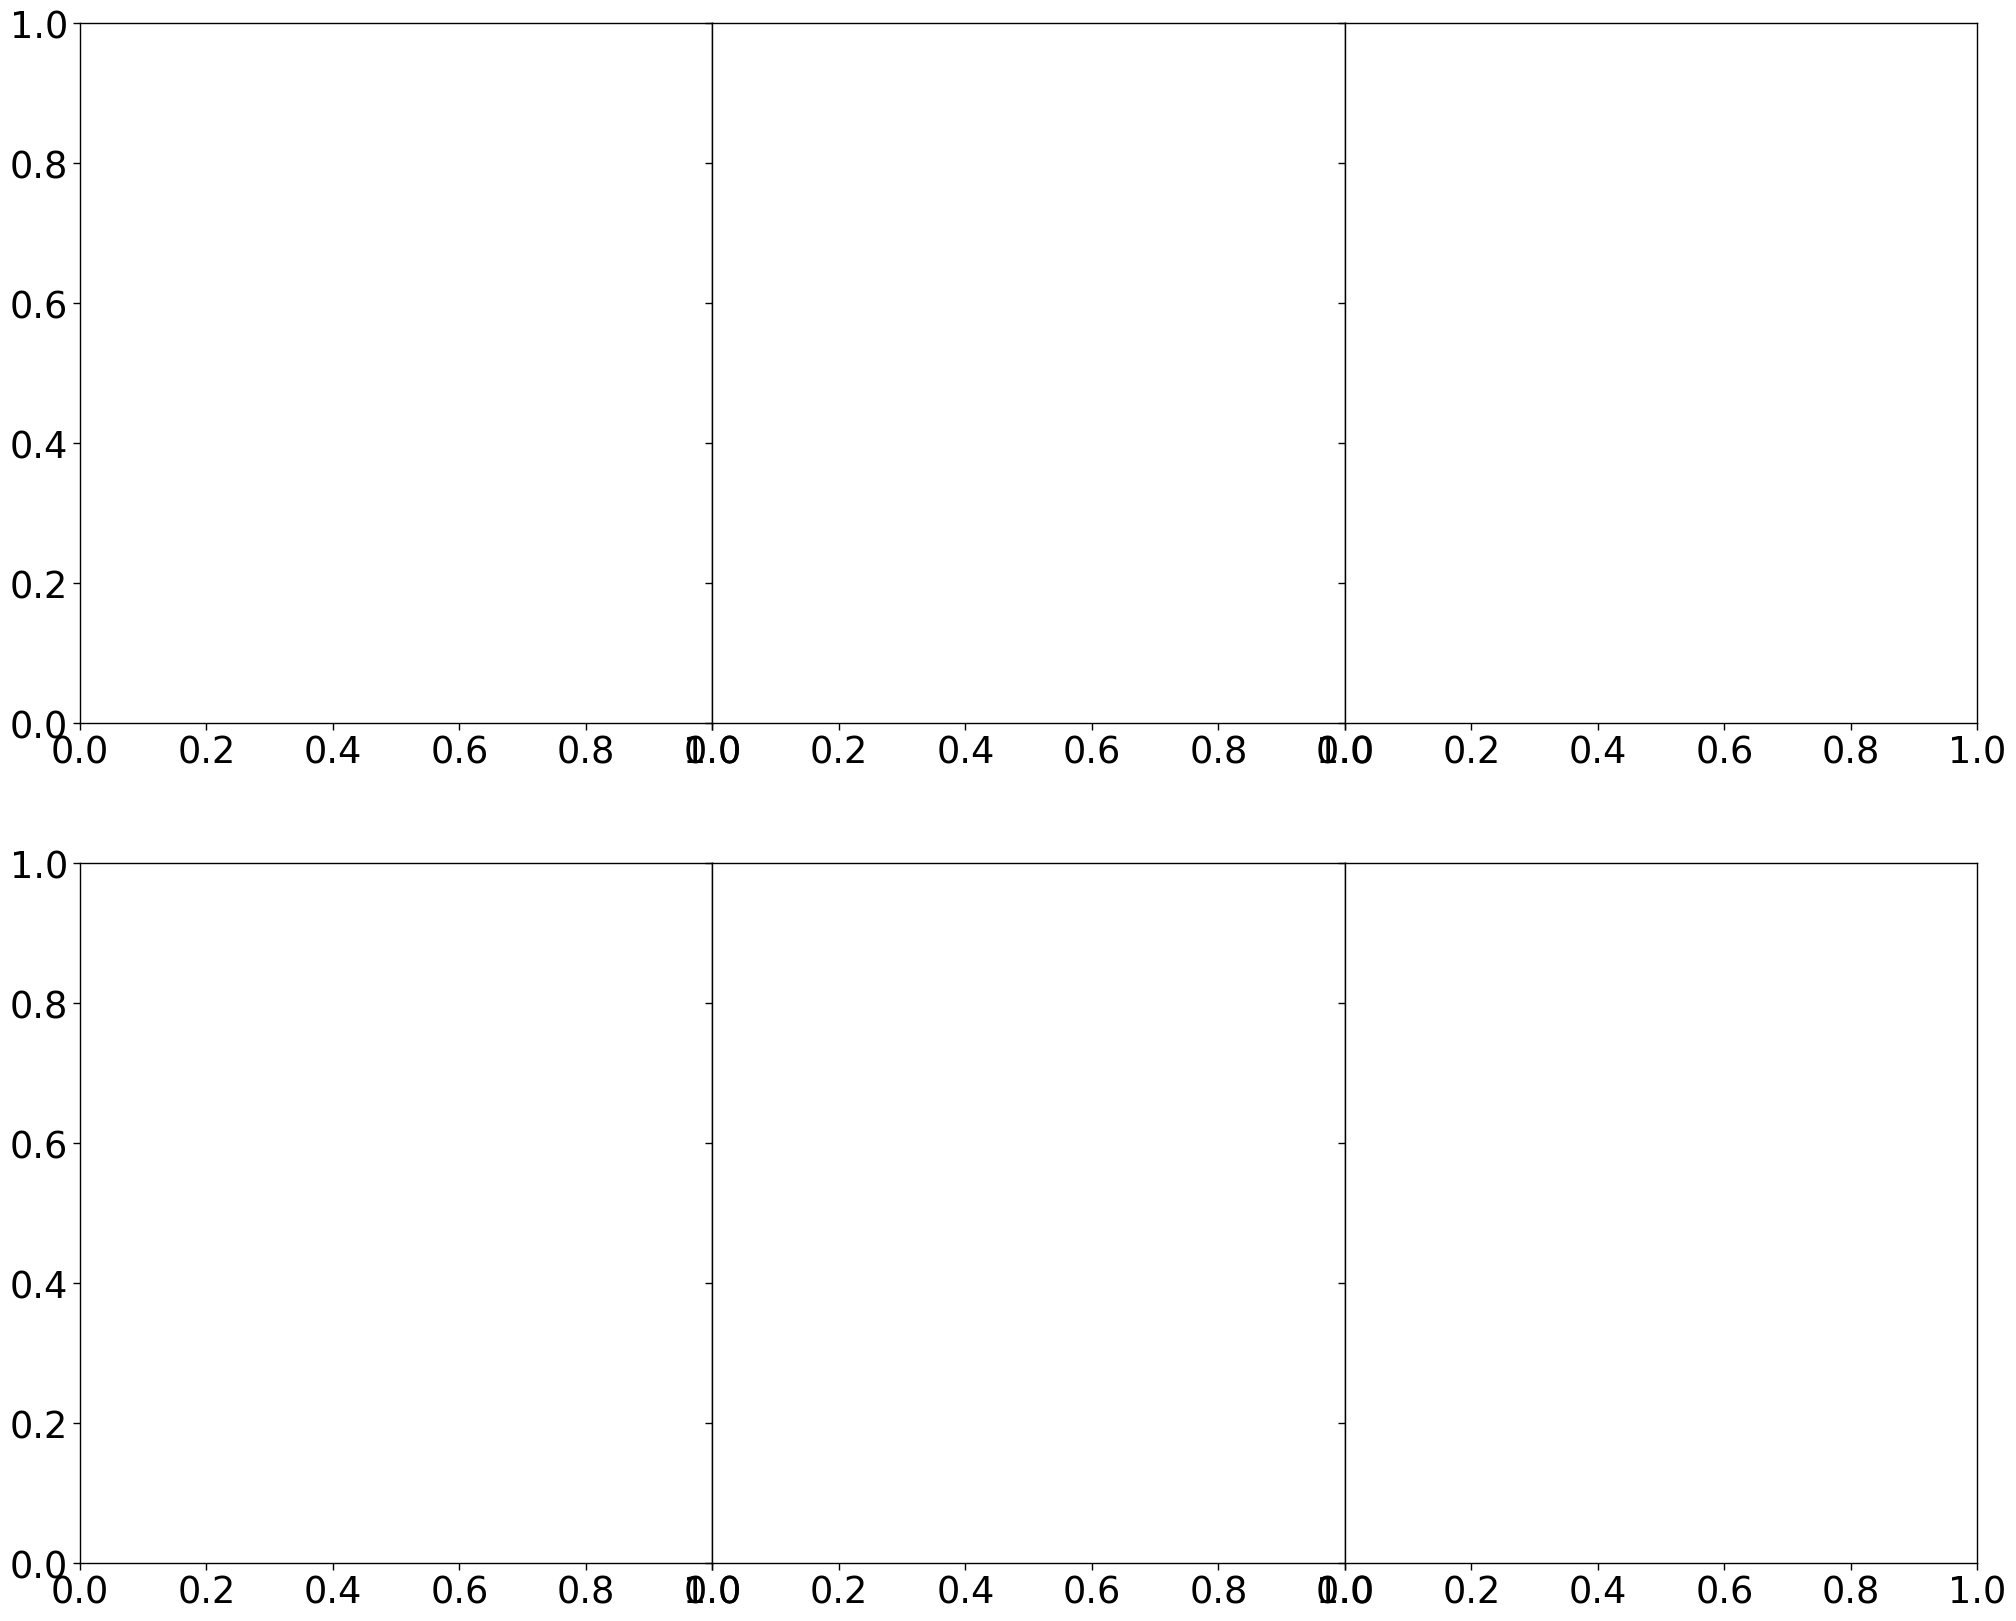

In [23]:
tests = ['training_softmax_prueba_13080mil','training_softmax_prueba_27620mil',
         'training_softmax_batchBalanced_prueba_27620mil',
         'training_softmax_prueba_69721mil',
         'training_softmax_batchBalanced_prueba_69721mil']
titles = ['Train-9 Undersampling','Train-24 Data Augmentation',
         'Train-24 Batch Balanced',
         'Train-60 Data Augmentation',
         'Train-60 Batch Balanced']

test = run_analysis(tests,titles,"entrenamientos/entrenamiento_8_sep/"
                   )


In [ ]:
df = metricas(test["categorical_label"],test["label_predict_training_softmax_batchBalanced_prueba_27620mil"])

In [ ]:
print(pd.DataFrame(df).T.to_latex())

In [ ]:
test.loc[(test["categorical_label"]!=7)&
        (test["label_predict_training_softmax_batchBalanced_prueba_27620mil"]==7)]

In [ ]:
plt.imshow(data["prueba_13080mil"][2220])

In [ ]:
#data = h5py.File("../data_Paper_OGLE/Data_08Sep.hdf5", 'r+')
#ogle = pd.read_csv("catalogos/ogle_no_usado.csv")
df_8mil = pd.read_csv("../data_Paper_OGLE/catalogos/prueba_8mil.csv")
idx_test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"].index.values
model_softmax = make_model()
model_softmax.load_weights("entrenamientos/entrenamiento_8_sep/training_softmax_batchBalanced_prueba_69721mil/cp.ckpt")
df = pd.DataFrame(model_softmax.predict(data["prueba_13080mil"][:]),columns=['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"Random"])
df_8mil = pd.concat([df_8mil,df],axis=1)
df_8mil = df_8mil.loc[df_8mil["categorical_label"]!=7]
X_train = df_8mil.loc[df_8mil["prueba_8mil"]!="test"][['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"Random",
         "per","amplitud","types","categorical_label"]]
X_test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"][['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"Random",
         "per","amplitud","types","categorical_label"]]

In [ ]:
train_random_forest(X_train.drop(columns={"types","categorical_label"}),
                   X_train["categorical_label"],
                   X_test.drop(columns={"types","categorical_label"}),
                   X_test["categorical_label"])